In [0]:
!unzip titanic.zip

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_curve, auc, accuracy_score)


In [0]:
'''
サンプルの生成
'''
train = pd.read_csv("train.csv")      # (891, 12)
test = pd.read_csv("test.csv")        # (418, 11)
full_data = [train, test]

train_len = len(train)      # 891
test_len = len(test)        # 418

In [0]:
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

In [0]:
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean()

In [0]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean()

In [0]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

In [0]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

In [0]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean()

In [0]:
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
train['CategoricalAge'] = pd.cut(train['Age'], 5)

train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean()


In [0]:
'''
データの前処理
'''
def missing_table(df):      # データの欠損を計算
    null_val = df.isnull().sum()
    percent = 100 * df.isnull().sum()/len(df)
    missing_table = pd.concat([null_val, percent], axis=1)
    missing_table_ren_columns = missing_table.rename(
        columns = {0:"欠損数", 1:"%"}
    )
    return missing_table_ren_columns

# missing_table(train)
# print(missing_table(test))

for i in range(len(train)):
  train["Name"][i] = train["Name"][i].split('.')[0].split(', ')[1]
for i in range(len(test)):
  test["Name"][i] = test["Name"][i].split('.')[0].split(', ')[1]

  
# 欠損の穴埋め
train["Cabin"] = train["Cabin"].fillna(0)
train["Age"] = train["Age"].fillna(train["Age"].median())
train["Embarked"] = train["Embarked"].fillna("S")
train["Sex"][train["Sex"]=="male"] = 0
train["Sex"][train["Sex"]=="female"] = 1
train["Embarked"][train["Embarked"]=="S"] = 0
train["Embarked"][train["Embarked"]=="C"] = 1
train["Embarked"][train["Embarked"]=="Q"] = 2

test["Cabin"] = test["Cabin"].fillna(0)
test["Age"] = test["Age"].fillna(test["Age"].median())
test["Sex"][test["Sex"]=="male"] = 0
test["Sex"][test["Sex"]=="female"] = 1
test["Embarked"][test["Embarked"]=="S"] = 0
test["Embarked"][test["Embarked"]=="C"] = 1
test["Embarked"][test["Embarked"]=="Q"] = 2
test["Fare"] = test["Fare"].fillna(test["Fare"].median())

train["Sex"] = pd.to_numeric(train["Sex"], errors='coerce')
train["Embarked"] = pd.to_numeric(train["Embarked"], errors='coerce')
test["Sex"] = pd.to_numeric(test["Sex"], errors='coerce')
test["Embarked"] = pd.to_numeric(test["Embarked"], errors='coerce')

In [0]:
for dataset in full_data:
    dataset.loc[ dataset['Cabin'] != 0, 'Cabin'] = 1
    
#     dataset.loc[ dataset['Name'] == 'Mr', 'Name'] = 1
#     dataset.loc[ dataset['Name'] == 'Miss', 'Name'] = 2
#     dataset.loc[ dataset['Name'] == 'Mrs', 'Name'] = 3
#     dataset.loc[ dataset['Name'] == 'Master', 'Name'] = 4
#     dataset.loc[(dataset['Name'] != 'Mr') & (dataset['Name'] != 'Miss') & (dataset['Name'] != 'Mrs') & (dataset['Name'] != 'Master'), 'Name'] = 0
    dataset['Name'] =  dataset['Name'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4})
  
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4
    
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

In [0]:
train['Name'] = train['Name'].fillna(0)
test['Name'] = test['Name'].fillna(0)

In [0]:
# 一人かどうか
alone_train = np.zeros((train_len))
for i in range(train_len):
    if train["Parch"][i].all()==0 and train["SibSp"][i].all()==0:
        alone_train[i] = 1
alone_test = np.zeros((test_len))
for i in range(test_len):
    if test["Parch"][i].all()==0 and test["SibSp"][i].all()==0:
        alone_test[i] = 1

list_alone_train = list(alone_train.astype(int))
pd_alone_train = pd.DataFrame({'Alone':alone_train})
train = pd.concat([train.reset_index(drop=True), pd_alone_train.reset_index(drop=True)], axis=1)
list_alone_test = list(alone_test.astype(int))
pd_alone_test = pd.DataFrame({'Alone':alone_test})
test = pd.concat([test.reset_index(drop=True), pd_alone_test.reset_index(drop=True)], axis=1)

In [0]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(8,6))
sns.heatmap(corrmat, vmax=.8, annot = True, center = 0)

In [0]:
# n_train = 791
val_ratio = 0.3
f_name = 'model_titanic_trained.h5'
# f_name = 'model_titanic_tset.h5'

In [0]:
'''
入力の生成
'''
train_dropped = train.drop(['PassengerId', 'Ticket'], axis=1)
train_x = train_dropped.drop('Survived', axis=1)
train_y = train_dropped.Survived


In [0]:
submit_dropped = test.drop(['PassengerId', 'Ticket'], axis=1)
submit_x = submit_dropped

(train_x, val_x, train_y, val_y) = train_test_split(train_x, train_y, test_size=val_ratio, random_state=666)       # random_stateのseedを適当に固定

In [0]:
train_x = np.array(train_x)
val_x = np.array(val_x)
train_y = np.array(train_y)
val_y = np.array(val_y)

In [0]:
train_x = train_x[:,:,np.newaxis]
val_x = val_x[:,:,np.newaxis]

In [13]:
train_x.shape

(623, 10, 1)

In [0]:
'''
モデルの生成
'''
from deep_forest import MGCForest
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

In [0]:
mgc_forest = MGCForest(
    estimators_config={
        'mgs': [{
            'estimator_class': ExtraTreesClassifier,
            'estimator_params': {
                'n_estimators': 30,
                'min_samples_split': 21,
                'n_jobs': -1,
            }
        }, {
            'estimator_class': RandomForestClassifier,
            'estimator_params': {
                'n_estimators': 30,
                'min_samples_split': 21,
                'n_jobs': -1,
            }
        }],
        'cascade': [{
            'estimator_class': ExtraTreesClassifier,
            'estimator_params': {
                'n_estimators': 1000,
                'min_samples_split': 11,
                'max_features': 1,
                'n_jobs': -1,
            }
        }, {
            'estimator_class': ExtraTreesClassifier,
            'estimator_params': {
                'n_estimators': 1000,
                'min_samples_split': 11,
                'max_features': 'sqrt',
                'n_jobs': -1,
            }
        }, {
            'estimator_class': RandomForestClassifier,
            'estimator_params': {
                'n_estimators': 1000,
                'min_samples_split': 11,
                'max_features': 1,
                'n_jobs': -1,
            }
        }, {
            'estimator_class': RandomForestClassifier,
            'estimator_params': {
                'n_estimators': 1000,
                'min_samples_split': 11,
                'max_features': 'sqrt',
                'n_jobs': -1,
            }
        }]
    },
    stride_ratios=[1.0 / 4, 1.0 / 9, 1.0 / 16],
)


In [0]:
'''
学習
'''
mgc_forest.fit(train_x, train_y)

In [0]:
'''
評価
'''
y_pred = mgc_forest.predict(val_x)

print('Prediction shape:', y_pred.shape)
print(
    'Accuracy:', accuracy_score(val_y, y_pred),
#     'F1 score:', f1_score(val_y, y_pred, average='weighted')
)


In [0]:
y_pred

In [0]:
'''
提出
'''
submit_mgc = mgc_forest.predict(np.array(submit_x))
submit_mgc = np.round(submit_mgc).astype(int)
submit_mgc = submit_mgc.flatten()

In [20]:
submit_mgc

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [0]:
submit_dnn = ([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0])

In [0]:
hard_predict_dnn = ([  2,   3,   5,   6,   8,   9,  10,  12,  13,  14,  15,  17,  22,
        24,  25,  26,  27,  29,  30,  31,  35,  38,  39,  40,  42,  43,
        44,  45,  47,  48,  55,  56,  57,  58,  59,  60,  62,  63,  65,
        66,  70,  71,  74,  76,  79,  81,  83,  85,  86,  88,  91,  92,
        93,  95,  97,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123, 124,
       126, 128, 129, 130, 133, 134, 135, 136, 137, 139, 140, 141, 142,
       143, 145, 147, 150, 151, 152, 154, 155, 156, 160, 162, 163, 167,
       168, 170, 171, 172, 173, 174, 175, 176, 178, 179, 182, 183, 184,
       186, 187, 188, 192, 195, 196, 200, 203, 206, 208, 209, 210, 211,
       214, 216, 218, 219, 220, 221, 222, 223, 224, 226, 227, 228, 231,
       232, 233, 235, 237, 238, 239, 240, 241, 243, 244, 246, 248, 250,
       251, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 265,
       267, 269, 271, 272, 273, 274, 275, 276, 277, 278, 282, 283, 284,
       285, 286, 288, 289, 291, 292, 294, 295, 296, 297, 299, 300, 302,
       303, 304, 305, 310, 311, 312, 313, 314, 315, 318, 319, 320, 321,
       322, 324, 325, 326, 328, 330, 332, 333, 334, 337, 339, 341, 342,
       343, 344, 345, 346, 347, 349, 350, 353, 354, 357, 358, 360, 361,
       362, 363, 364, 366, 368, 370, 371, 373, 374, 375, 379, 380, 381,
       384, 385, 386, 387, 388, 389, 391, 392, 393, 394, 395, 396, 397,
       398, 400, 401, 402, 406, 408, 409, 410, 411, 413, 414, 415, 416,
       417])

In [0]:
j = 0
h = 0
mix = []
for i in range(len(submit_mgc)):
    if submit_mgc[i] != submit_dnn[i]:
        frag = 0
        for t in range(len(hard_predict_dnn)):
            if hard_predict_dnn[t]== i:
                mix.append(submit_dnn[i])
                frag += 1
                h += 1
        if frag==0:
            mix.append(submit_mgc[i])
        j += 1
    else:
        mix.append(submit_mgc[i])
print(j,h,len(mix))

48 5 418


In [0]:
submit_mix = np.array(mix)

In [0]:
# PassengerIdを取得
PassengerId = np.array(test["PassengerId"]).astype(int)
 
# my_prediction(予測データ）とPassengerIdをデータフレームへ落とし込む
my_solution = pd.DataFrame(submit_mgc, PassengerId, columns = ["Survived"])
# my_solution = pd.DataFrame(submit_mix, PassengerId, columns = ["Survived"])
 
# my_tree_one.csvとして書き出し
my_solution.to_csv("nn.csv", index_label = ["PassengerId"])

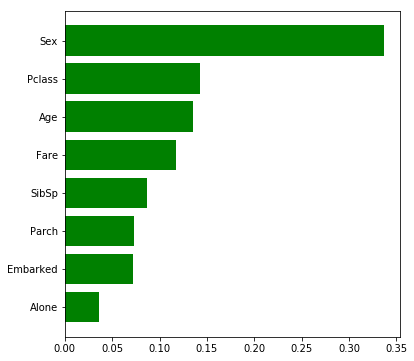

In [0]:
'''
変数重要度の可視化
'''
import matplotlib.pyplot as plt

features = train_x.columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()